In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf
import numpy as np
import os
import re
import collections
import time 

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'dbSNP', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath, dbsnp_dict):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = rsid.split("_")[0][3:]
            pos   = int(arr[2])
            p     = float(arr[7])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[3])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, dbSNP=dbsnp_dict[rsid], maf=maf))
    return res

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get dbSNP 151 rsids

In [4]:
import gzip 

dbsnp_dict = dict()
with gzip.open("/cbscratch/franco/datasets/gtex_v8/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.lookup_table.txt.gz") as instream:
    next(instream)
    for line in instream:
        arr = line.decode().rstrip().split()
        #if len(arr[3]) == 1 and len(arr[4]) == 1:
        dbsnp_dict[arr[2]] = arr[6]

# Load Trans-eQTLS

In [5]:
from utils import utils
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/analysis/plots/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)

expr = "raw"
preproc = "permnull_sb0.1_knn30"

basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/"
trans_dict = dict()
sumdir = os.path.join(basepath, expr, "summary_5e-08")
for tissue in tissuenames:
    tejaas_file = os.path.join(sumdir, tissue, "tejaas", preproc, "trans_eqtls.txt")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    print("Loading ", tissue)
    transeqtls = tejaas(tejaas_file, dbsnp_dict)
    if len(transeqtls) > 0:
        trans_dict[tissue] = transeqtls
    else:
        trans_dict[tissue] = []
        print("{:s} has 0 trans-eqtls".format(tissue))

Loading  as
Loading  av
Loading  ag
Loading  aa
Loading  ac
Loading  at
Loading  bam
Loading  ban
Loading  bca
Loading  bceh
Loading  bce
Loading  bco
Loading  bfr
Loading  bhi
Loading  bhy
Loading  bnu
Loading  bpu
Loading  bsp
Loading  bsu
Loading  br
Loading  ebv
Loading  fib
Loading  cols
Loading  colt
Loading  esog
Loading  esom
Loading  esomu
Loading  haa
haa has 0 trans-eqtls
Loading  hlv
Loading  kc
Loading  liv
Loading  lu
Loading  msg
Loading  ms
Loading  nt
Loading  pan
pan has 0 trans-eqtls
Loading  pit
Loading  snse
Loading  sse
Loading  si
Loading  spl
Loading  sto
Loading  thy
Loading  wb
wb has 0 trans-eqtls
Loading  ov
Loading  pro
Loading  tes
Loading  ut
Loading  va
va has 0 trans-eqtls
Loading  bl


# Load GWAS Catalog

In [6]:
gwas_cat = "/cbscratch/franco/datasets/GWAScatalog/gwas_catalog_v1.0-associations_e98_r2019-12-16.tsv"
gwas_pos_dict = collections.defaultdict(dict)
skip = 0
loaded = 0
weird_snps = list()
gwas_rsid_dict = collections.defaultdict(lambda: False)
gwas_rsid_trait = dict()
gwas_rsid_list = list()
with open(gwas_cat) as instream:
    header = instream.readline().rstrip().split("\t")
    # header[17] SNP_GENE_IDS
    print( header[7], header[11], header[12], header[21], header[22], header[23], header[27])
    for line in instream:
        arr = line.rstrip().split("\t")
        # df_gwas.iloc[:,[12,23,27]]
        trait = arr[7]
        chrm  = arr[11]
        bp_pos= arr[12]
        snps  = arr[21]
        snp_id_current = arr[23]
        pval  = arr[27]
        if re.search(";", snps):
            bp_pos_arr = bp_pos.split(";")
            snps_arr   = snps.split(";")
            chrm_arr   = chrm.split(";")
            # print(bp_pos_arr, snps_arr)
            if len(bp_pos_arr) != len(snps_arr) and len(snps_arr) != len(chrm_arr):
                if len(bp_pos_arr) == len(chrm_arr):
                    new_snps_arr = [s.strip() for s in snps_arr if s.strip().startswith('rs')]
                    if len(new_snps_arr) == len(bp_pos_arr):
                        print("good!", new_snps_arr, bp_pos_arr, chrm_arr)
                        for i in range(len(new_snps_arr)):
                            gwas_rsid_list.append(new_snps_arr[i])
                            gwas_pos_dict[chrm_arr[i]][bp_pos_arr[i]] = new_snps_arr[i]
                            loaded += 1
                    else:
                        print("wtf!", snps_arr, new_snps_arr, bp_pos_arr, chrm_arr)
                        skip += 1
                else:
                    skip += 1
                    print(bp_pos_arr, snps_arr, chrm_arr)
                    weird_snps.append((bp_pos_arr, snps_arr, chrm_arr))
                    continue
            else:
                for s in snps_arr:
                    if s.strip().startswith('rs'):
                        gwas_rsid_dict[s.strip()] = True
                        gwas_rsid_trait[s.strip()] = trait
                        gwas_rsid_list.append(s.strip())
                        loaded += 1
                    else:
                        print("WTF, ",s)
            if len(bp_pos_arr) == len(snps_arr) and len(snps_arr) == len(chrm_arr):
                for i in range(len(snps_arr)):
                    gwas_pos_dict[chrm_arr[i]][bp_pos_arr[i]] = snps_arr[i]
                    loaded += 1
        else:
            if snps.startswith('rs'):
                gwas_rsid_dict[snps] = True
                gwas_rsid_trait[snps] = trait
                gwas_rsid_list.append(snps)
                gwas_pos_dict[chrm][bp_pos] = snps
                loaded += 1
            else:
                pass
                # print("not rs snp?!", snps, chrm, bp_pos)
print("Skipped {:d} GWAS snps".format(skip))
print("{:d} GWAS SNPs loaded".format(loaded))

DISEASE/TRAIT CHR_ID CHR_POS SNPS MERGED SNP_ID_CURRENT P-VALUE
good! ['rs10871290'] ['74438798'] ['16']
good! ['rs9272105'] ['32632222'] ['6']
wtf! ['rs6470588', ' rs35252396', ' rs6470589'] ['rs6470588', 'rs35252396', 'rs6470589'] ['127877125', '127877126'] ['8', '8']
wtf! ['rs32282', ' rs282072', ' rs10491363'] ['rs32282', 'rs282072', 'rs10491363'] [''] ['']
wtf! ['rs247547', ' rs247548', ' rs428987', ' rs437265', ' rs381463', ' rs388796', ' rs382900', ' rs10054105', ' rs3851455'] ['rs247547', 'rs247548', 'rs428987', 'rs437265', 'rs381463', 'rs388796', 'rs382900', 'rs10054105', 'rs3851455'] ['111561622', '111574957', '111573636'] ['5', '5', '5']
wtf! ['rs247547', ' rs247548', ' rs428987', ' rs437265', ' rs381463', ' rs388796', ' rs382900', ' rs10054105', ' rs3851455'] ['rs247547', 'rs247548', 'rs428987', 'rs437265', 'rs381463', 'rs388796', 'rs382900', 'rs10054105', 'rs3851455'] ['111561622', '111574957', '111573636'] ['5', '5', '5']
wtf! ['rs12055146', ' rs7709933'] ['rs12055146', '

wtf! ['rs17862966', ' rs6534043', ' rs10019567', ' rs2635296', ' rs1352576'] ['rs17862966', 'rs6534043', 'rs10019567', 'rs2635296', 'rs1352576'] ['117598351', '117611472', '117598611'] ['4', '4', '4']
wtf! ['rs17862966', ' rs6534043', ' rs10019567', ' rs2635296', ' rs1352576'] ['rs17862966', 'rs6534043', 'rs10019567', 'rs2635296', 'rs1352576'] ['117598351', '117611472', '117598611'] ['4', '4', '4']
wtf! ['rs7690486', ' rs17050894', ' rs7690678', ' rs1948435', ' rs1873867', ' rs12504035'] ['rs7690486', 'rs17050894', 'rs7690678', 'rs1948435', 'rs1873867', 'rs12504035'] ['130191421', '130200094'] ['4', '4']
wtf! ['rs7690486', ' rs17050894', ' rs7690678', ' rs1948435', ' rs1873867', ' rs12504035'] ['rs7690486', 'rs17050894', 'rs7690678', 'rs1948435', 'rs1873867', 'rs12504035'] ['130191421', '130200094'] ['4', '4']
wtf! ['rs4835564', ' rs6828493'] ['rs4835564', 'rs6828493'] [''] ['']
wtf! ['rs2056168', ' rs10027671'] ['rs2056168', 'rs10027671'] [''] ['']
wtf! ['rs7375984', ' rs1492458', ' r

Skipped 326 GWAS snps
182308 GWAS SNPs loaded


In [7]:
total_gwas_snps = len(set(gwas_rsid_list))
print("number of unique GWAS SNPs:", total_gwas_snps, len(gwas_rsid_list))

number of unique GWAS SNPs: 107895 171444


# Number of SNPs from GTEX v8 in GWAS Catalog

In [8]:
genome_pos_dict = collections.defaultdict(dict)
snp_infile = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_0.01/gtex_v8_snpinfo.txt"
in_gwas_cat = 0
out_gwas_cat = 0
gtex_snps = 0
with open(snp_infile) as instream:
    for line in instream:
        gtex_snps += 1
        arr = line.rstrip().split()
        chrm = arr[0]
        snpid = arr[1]
        pos = arr[2]
        maf = arr[5]
        dbsnp_id = dbsnp_dict.get(snpid, False)
        if dbsnp_id and gwas_rsid_dict[dbsnp_id]:
            in_gwas_cat += 1
print("SNPs in GWAS catalog:", total_gwas_snps)
print("GTEx SNPs in GWAS catalog:", in_gwas_cat)
print("Total nº of GTEx SNPS:",gtex_snps)
print("fraction of snps in GWAS:", in_gwas_cat/gtex_snps)
# SNPs in GWAS catalog: 95512
# GTEx SNPs in GWAS catalog: 35452
# Total nº of GTEx SNPS: 4522283
# fraction of snps in GWAS: 0.007839403239469975

SNPs in GWAS catalog: 107895
GTEx SNPs in GWAS catalog: 40661
Total nº of GTEx SNPS: 4522283
fraction of snps in GWAS: 0.00899125508067496


In [31]:
gwas_hits = list()
gwas_hits_dict = collections.defaultdict(list)
for tissue in tissuenames:
    types_dict = collections.defaultdict(int)
    if tissue in trans_dict:
        in_gwas = 0
        if len(trans_dict[tissue]) > 0:
            for snp in trans_dict[tissue]:
                if gwas_rsid_dict[snp.dbSNP]:
                    in_gwas += 1
                    gwas_hits.append(snp.rsid)
                    gwas_hits_dict[tissue].append(snp)
                    types_dict[gwas_rsid_trait[snp.dbSNP]] += 1
            print("{:s}\t{:d}\t{:d}\t{:g}".format(tissue, in_gwas, len(trans_dict[tissue]), in_gwas / len(trans_dict[tissue])))
        else:
            print("{:s}\t{:d}\t{:d}\t{:g}".format(tissue, 0, len(trans_dict[tissue]), 0 ))
    #         for k in types_dict.keys():
    #             print("\t", k, types_dict[k])

as	20	1280	0.015625
av	20	671	0.0298063
ag	16	349	0.0458453
aa	64	2615	0.0244742
ac	75	3479	0.0215579
at	17	920	0.0184783
bam	24	2598	0.00923788
ban	24	2064	0.0116279
bca	0	18	0
bceh	3	157	0.0191083
bce	0	49	0
bco	2	76	0.0263158
bfr	0	33	0
bhi	2	108	0.0185185
bhy	0	207	0
bnu	16	663	0.0241327
bpu	0	7	0
bsp	0	86	0
bsu	0	40	0
br	25	841	0.0297265
ebv	12	514	0.0233463
fib	14	390	0.0358974
cols	4	138	0.0289855
colt	85	2198	0.0386715
esog	0	30	0
esom	0	90	0
esomu	0	35	0
haa	0	0	0
hlv	22	437	0.0503432
kc	0	17	0
liv	0	83	0
lu	25	907	0.0275634
msg	0	4	0
ms	98	4827	0.0203025
nt	18	1573	0.0114431
pan	0	0	0
pit	3	11	0.272727
snse	43	1411	0.0304748
sse	25	642	0.0389408
si	2	133	0.0150376
spl	1	5	0.2
sto	16	453	0.0353201
thy	41	2658	0.0154251
wb	0	0	0
ov	18	178	0.101124
pro	42	2101	0.0199905
tes	63	2344	0.0268771
ut	62	3506	0.017684
va	0	0	0
bl	12	220	0.0545455


In [32]:
print(f"Total hits: {len(gwas_hits)}")
print(f"Total unique hits: {len(set(gwas_hits))}")

Total hits: 914
Total unique hits: 379


In [33]:
def snpid_in_GWAS_catalog(snpids, gwas_dbsnp_dict):
    in_gwas = 0
    for snp in snpids:
        if gwas_dbsnp_dict[snp]:
            in_gwas += 1
    return in_gwas

def snp_in_GWAS_catalog(snplist, gwas_dbsnp_dict):
    in_gwas_ld = 0
    
    snpids = [snp.dbSNP for snp in snplist]
    in_gwas = snpid_in_GWAS_catalog(snpids, gwas_dbsnp_dict)
    # To check if that SNP is in LD with other SNPs that might be in the GWAS Catalog
    # Total Failure :(
    # elif LD_gw_dict[snp.chrom].get(str(snp.pos), False):
    #     for pos in LD_gw_dict[snp.chrom][str(snp.pos)]:
    #         # print(snp.chrom, pos)
    #         if gwas_pos_dict[str(snp.chrom)].get(str(pos), False):
    #             # print("yay!", snp.chrom, pos, gwas_pos_dict[str(snp.chrom)][str(pos)])
    #             in_gwas_ld += 1
    return in_gwas


In [34]:
import random
from statsmodels.distributions.empirical_distribution import ECDF

def sample_background_50000(dbsnp_dict, gwas_rsid_dict):
    randtrans = list()
    chroms    = [str(x) for x in np.arange(1,23)]
    for nid in ["{:03d}".format(x) for x in np.arange(1, 11)]:
        Nrand="50000"
        randomfile = "/usr/users/fsimone/vcfs_0.01/random_"+Nrand+"_"+nid

        rand_ids = list()
        for chrm in chroms:
            with open(os.path.join(randomfile, "chr{:s}.txt".format(chrm))) as ins:
                rand_ids += [dbsnp_dict[line.rstrip()] for line in ins]

        a = snpid_in_GWAS_catalog(rand_ids, gwas_rsid_dict)
        randtrans.append( a )
    return np.mean(randtrans), np.std(randtrans)

def sample_1000_pval(dbsnp_dict, gwas_rsid_dict, ntrans):
    randtrans = list()
    chroms    = [str(x) for x in np.arange(1,23)]
    start = time.time()
    for nid in ["{:05d}".format(x) for x in np.arange(1, 1001)]:
        Nrand="10000"
        randomfile = "/usr/users/fsimone/vcfs_0.01/random_"+Nrand+"_"+nid

        rand_ids = list()
        for chrm in chroms:
            with open(os.path.join(randomfile, "chr{:s}.txt".format(chrm))) as ins:
                rand_ids += [dbsnp_dict[line.rstrip()] for line in ins]
        
        sampled_rand_ids = random.sample(rand_ids, ntrans)
        a = snpid_in_GWAS_catalog(sampled_rand_ids, gwas_rsid_dict)
        randtrans.append( a )
    end = time.time()
    # print("Sampling took {:g} seconds".format( end-start))
    return np.array(randtrans)/ntrans

def sample_1000_binomial(ntrans, background):
    randtrans = sample_binomial(ntrans, background, 1000000)
    return np.array(randtrans)/ntrans

def sample_binomial(n, p, NTIMES):
    array_n = list()
    for i in range(NTIMES):
        n_success = np.random.binomial(n, p)
        array_n.append(n_success)
    return array_n

def GWAS_enrichment_pval(null_rands, GWAS_BG, enrichment):
    null_enrichments = [ x/GWAS_BG for x in null_rands]
    ecdf = ECDF(null_enrichments)
    pval = 1 - ecdf(enrichment)
    return pval

GWAS_FIELDS = ['tissue', 'inGWAS', 'nTrans', 'enrichment', 'pval']
class GWAS(collections.namedtuple('_GWAS', GWAS_FIELDS)):
    __slots__ = ()

In [39]:
rand_in_gwas_avg, rand_in_gwas_std = sample_background_50000(dbsnp_dict, gwas_rsid_dict)
print(rand_in_gwas_avg, rand_in_gwas_std, rand_in_gwas_avg/50000)

GWAS_BG = rand_in_gwas_avg/50000

453.5 21.541819793137254 0.00907


In [40]:
import scipy.stats as ss

print("{: >6}\t{: >6}\t{: >6}\t{: >9}\t{: >9}\t{: >9}".format("Tissue","inGWAS","nTrans","enrichment", "pval", "pval_binom"))
GWAS_enrichment_results = list()
for tissue in tissuenames:
    if tissue in trans_dict:
        ntrans = len(trans_dict[tissue])
        
        if ntrans > 0:
            in_gwas = snp_in_GWAS_catalog(trans_dict[tissue], gwas_rsid_dict)
            frac_in_gwas = in_gwas / ntrans
            enrichment = frac_in_gwas / GWAS_BG

            # randfrac_1000_gwas_old = sample_1000_pval(dbsnp_dict, gwas_rsid_dict, ntrans)
            randfrac_1000_gwas_binomial = sample_1000_binomial(ntrans, GWAS_BG)
            # gpval_old = GWAS_enrichment_pval(randfrac_1000_gwas_old, GWAS_BG, enrichment)
            gpval     = GWAS_enrichment_pval(randfrac_1000_gwas_binomial, GWAS_BG, enrichment)
            pval_binom = ss.binom_test(in_gwas, ntrans, GWAS_BG, alternative='greater')
        else:
            gpval=1.0
            pval_binom=1.0
            in_gwas=0
            enrichment=0
    
        GWAS_res = GWAS(tissue=tissue, inGWAS=in_gwas, nTrans=len(trans_dict[tissue]), enrichment=enrichment, pval=pval_binom)
        GWAS_enrichment_results.append(GWAS_res)
        print("{: >6}\t{: >6}\t{: >6}\t{:10g}\t{:10g}\t{:10g}".format(tissue, in_gwas, len(trans_dict[tissue]), enrichment, gpval, pval_binom))
        

Tissue	inGWAS	nTrans	enrichment	     pval	pval_binom
    as	    20	  1280	   1.72271	   0.00813	 0.0152389
    av	    20	   671	   3.28625	     1e-06	5.52389e-06
    ag	    16	   349	   5.05461	         0	2.00303e-07
    aa	    64	  2615	   2.69837	         0	4.58116e-12
    ac	    75	  3479	   2.37684	         0	2.77246e-11
    at	    17	   920	   2.03729	  0.002371	0.00534762
   bam	    24	  2598	   1.01851	  0.410192	   0.49169
   ban	    24	  2064	   1.28202	  0.094088	  0.134801
   bca	     0	    18	         0	   0.15163	         1
  bceh	     3	   157	   2.10676	  0.055797	  0.171685
   bce	     0	    49	         0	  0.359907	         1
   bco	     2	    76	   2.90141	  0.031904	  0.151607
   bfr	     0	    33	         0	  0.259428	         1
   bhi	     2	   108	   2.04173	  0.075658	  0.256685
   bhy	     0	   207	         0	  0.848273	         1
   bnu	    16	   663	   2.66072	  0.000149	0.000484928
   bpu	     0	     7	         0	  0.061984	         1
   bsp	     0	    86	   

In [44]:
gwas_outdir = os.path.join(sumdir, "GWAS", preproc)
if not os.path.exists(gwas_outdir): 
    os.makedirs(gwas_outdir)
with open(os.path.join(gwas_outdir,"GWAS_enrichment_results_01_2020.txt"), 'w') as outstream:
    outstream.write("{:s}\t{:s}\t{:s}\t{:s}\t{:s}\n".format("Tissue","inGWAS","nTrans","enrichment", "pval"))
    for e in GWAS_enrichment_results:
        outstream.write("{:s}\t{:d}\t{:d}\t{:g}\t{:g}\n".format(e.tissue, e.inGWAS, e.nTrans, e.enrichment, e.pval))

# Make Plot

In [45]:
import json
import os 
from utils import utils

#from utils import mpl_stylesheet
#mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

json_file = "../../gtex_v8_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_samples = dict()
for tshort, tfull in zip(tissuenames, descriptions):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

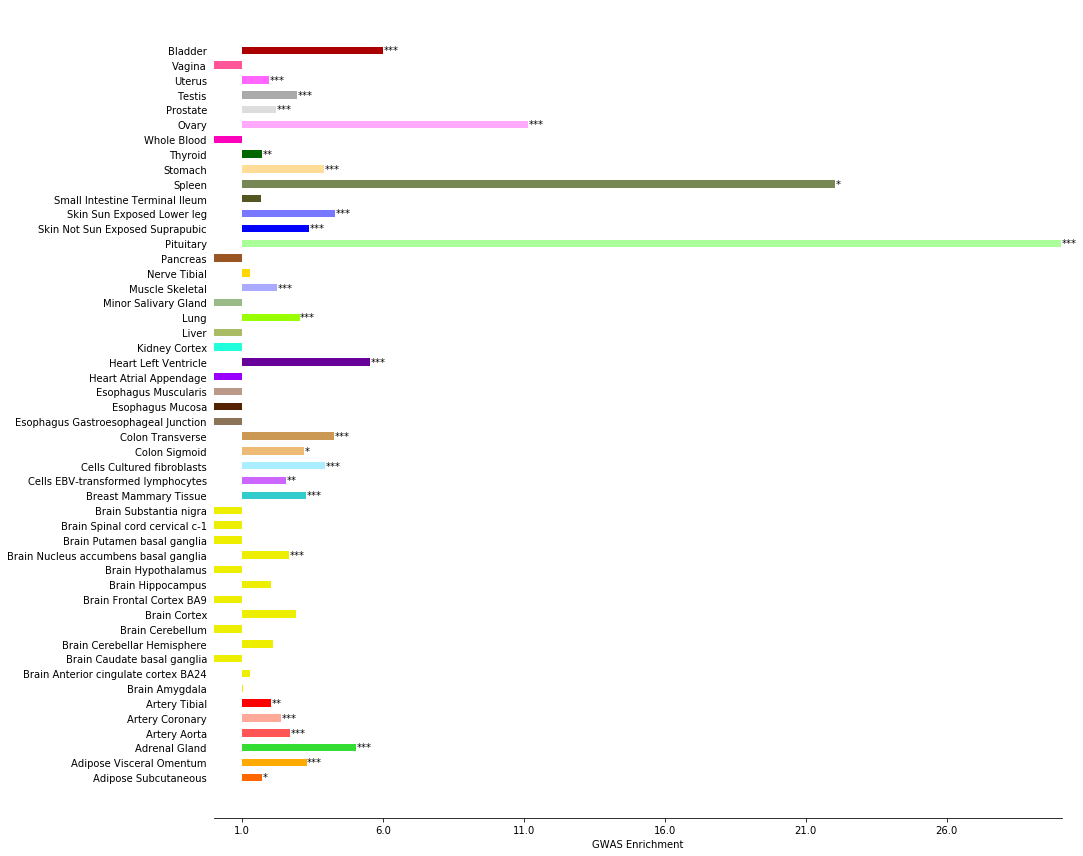

In [46]:
# read file
GWAS_results = list()
with open(os.path.join(gwas_outdir,"GWAS_enrichment_results_01_2020.txt")) as instream:
    next(instream)
    for line in instream:
        arr = line.rstrip().split()
        tissue = arr[0]
        in_gwas = int(arr[1])
        nTrans = int(arr[2])
        enrichment = float(arr[3])
        pval = float(arr[4])
        GWAS_results.append(GWAS(tissue=tissue, inGWAS=in_gwas, nTrans=nTrans, enrichment=enrichment, pval=pval))
    

objects = list()
performance = list()
significance = list()
bar_colors = list()
bar_width = list()

for e in GWAS_results:
    tshort = e.tissue
    objects.append(tissue_names[tshort])
    performance.append(e.enrichment - 1.0)
    if e.pval <= 0.001:
        significance.append('***')
    elif e.pval <= 0.01:
        significance.append('**')
    elif e.pval <= 0.05:
        significance.append('*')
    else:
        significance.append('')
    bar_colors.append(tissue_colors[tshort])
    bar_width.append(tissue_samples[tshort])

bar_width = 0.5 # np.array(bar_width)

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = bar_width)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('GWAS Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

outfile = "GWAS_enrichment_01_2020.png"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

# 87 GWAS Studies for GTEx v8

In [152]:
def read_gwas_result(filepath):
    rsids = list()
    studies = collections.defaultdict(list)
    matrix = list()
    with open(filepath) as instream:
        header = instream.readline().strip().split("\t")
        study_names = header[1:]
        for line in instream:
            arr = line.strip().split("\t")
            rsid = arr[0]
            values = np.array([float(x) for x in arr[1:]])
            #values[values < 1e-100] = np.nan
            values[values == 0] = np.nan
            rsids.append(rsid)
            matrix.append(values)
    if len(matrix) > 0:
        matrix = np.array(matrix)
        for i,st in enumerate(study_names):
            studies[st] = matrix[:,i]
    return rsids, matrix, studies
            

In [156]:
res_gwas_dict = dict()
res_file = "all_gwas_pvals_{:s}.tsv"
for tissue in tissuenames:
    print(tissue)
    # rsids, values, studies
    res_gwas_dict[tissue] = read_gwas_result(os.path.join(sumdir,"GWAS", "gwas_pvals",res_file.format(tissue)))
    

as
av
ag
aa
ac
at
bam
ban
bca
bceh
bce
bco
bfr
bhi
bhy
bnu
bpu
bsp
bsu
br
ebv
fib
cols
colt
esog
esom
esomu
haa
hlv
kc
liv
lu
msg
ms
nt
pan
pit
snse
sse
si
spl
sto
thy
wb
ov
pro
tes
ut
va
bl


In [137]:
df_metadata = pd.read_csv("/cbscratch/franco/datasets/GWAS_GTEx_v8/gwas_metadata.txt", header=0, sep="\t")
study_catg = dict(zip("imputed_"+df_metadata.Tag, df_metadata.Category))
study_abbr = dict(zip("imputed_"+df_metadata.Tag, df_metadata.new_abbreviation))
study_name = dict(zip("imputed_"+df_metadata.Tag, df_metadata.new_Phenotype))

In [163]:
gwas_studycat = dict()
for tissue in tissuenames:
    cat_dict = collections.defaultdict(list)
    studies = res_gwas_dict[tissue][2]
    for st in studies:
        cat_dict[study_catg[st]] += list(studies[st][~np.isnan(studies[st])])
    gwas_studycat[tissue] = cat_dict

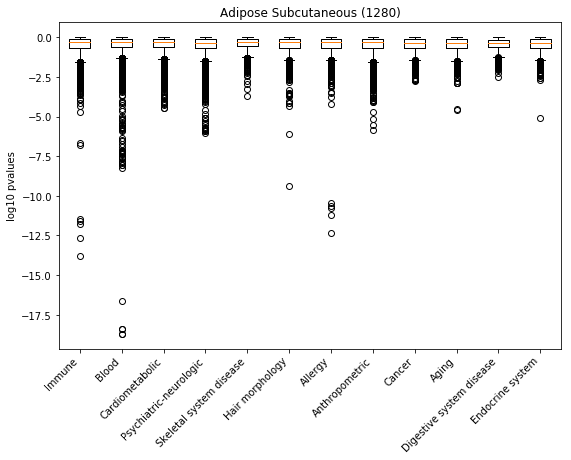

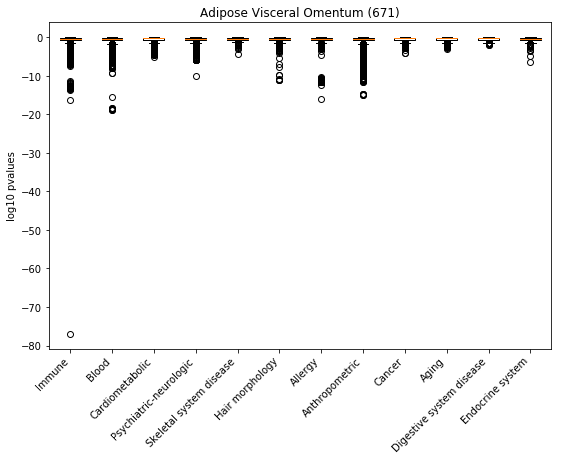

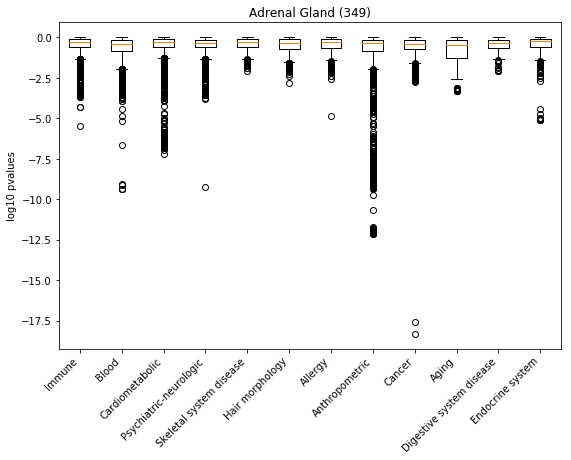

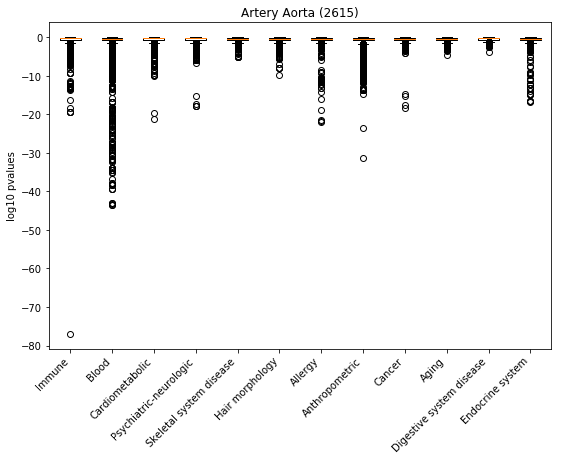

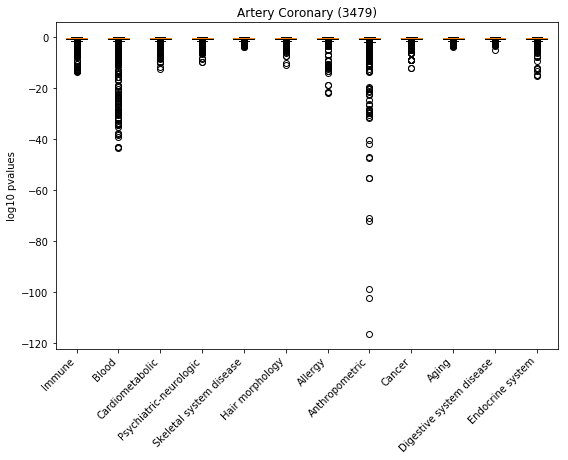

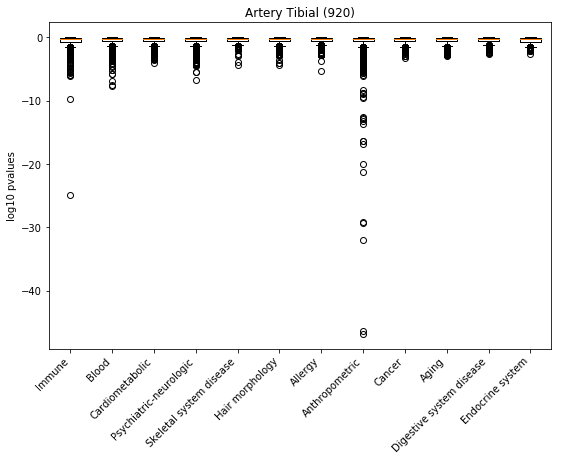

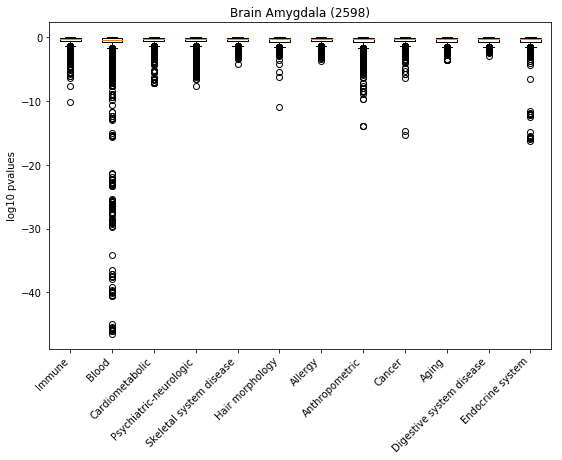

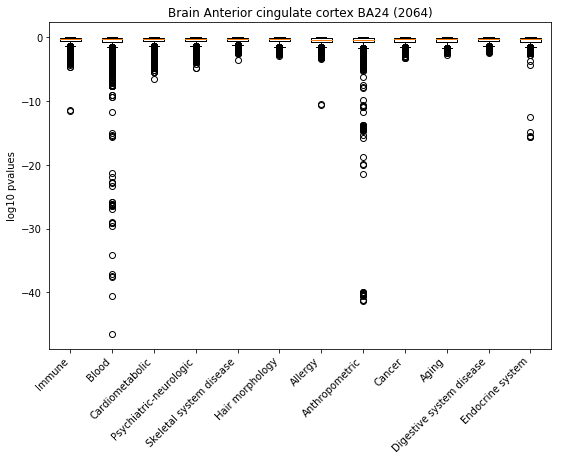

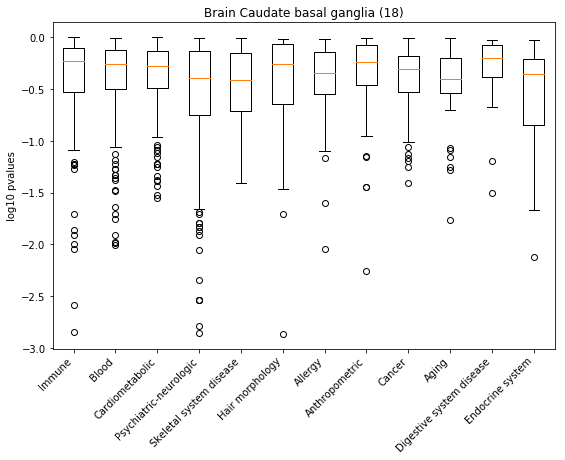

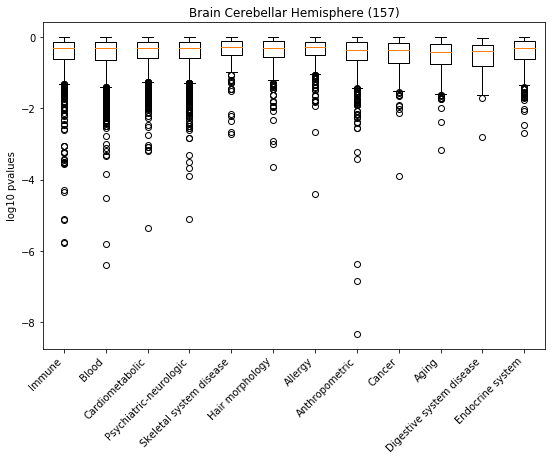

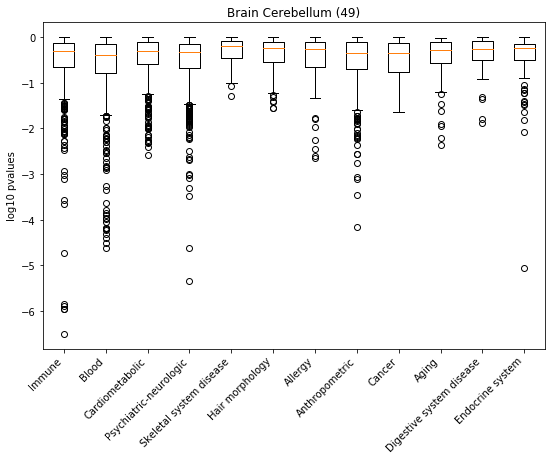

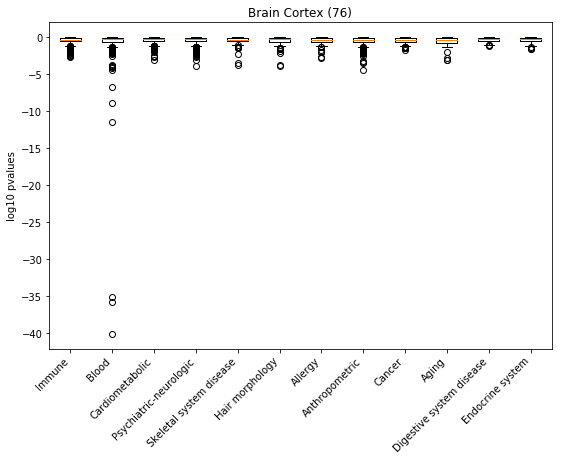

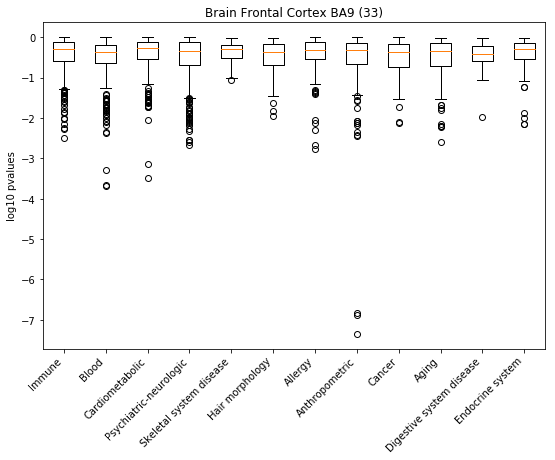

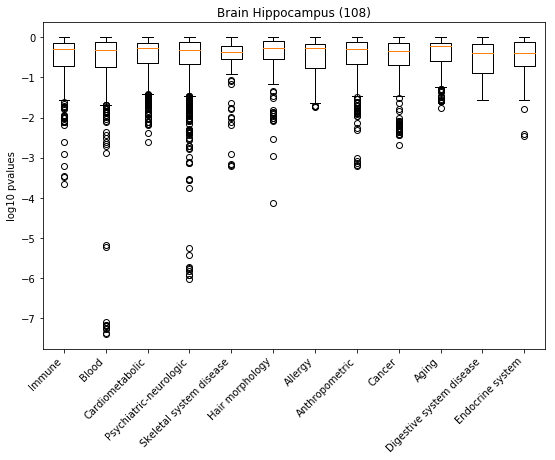

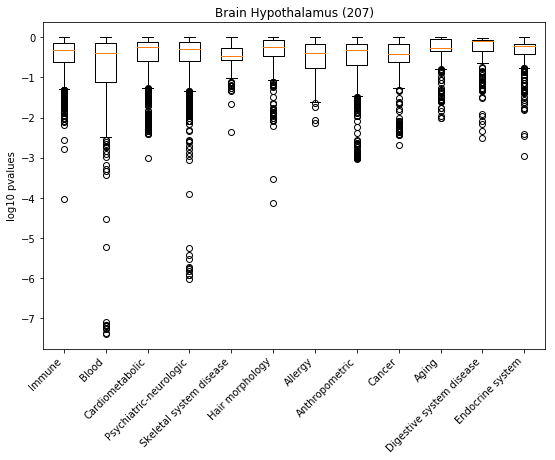

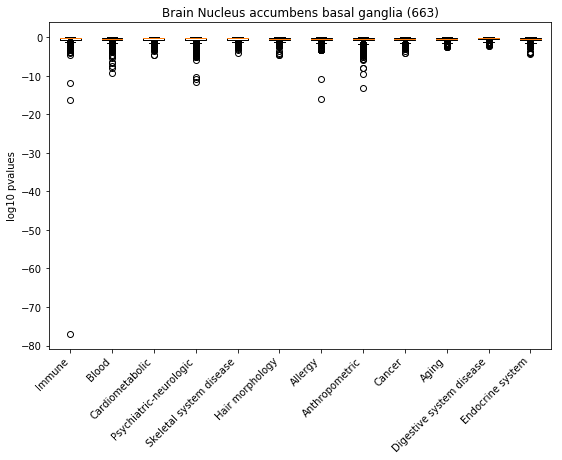

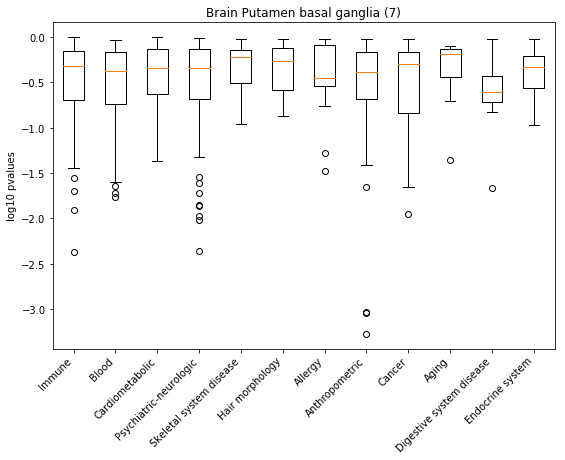

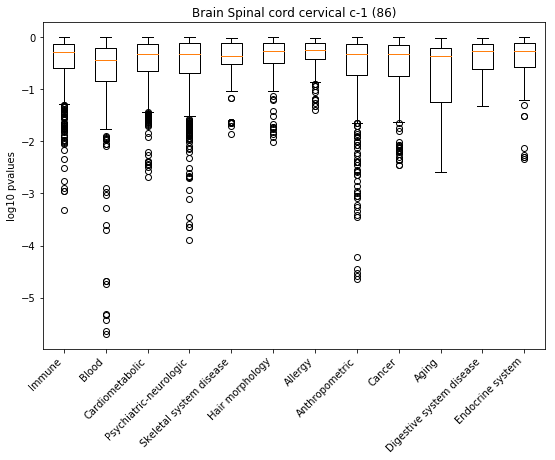

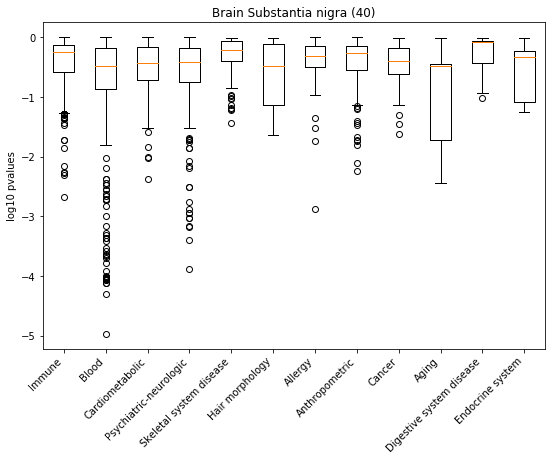

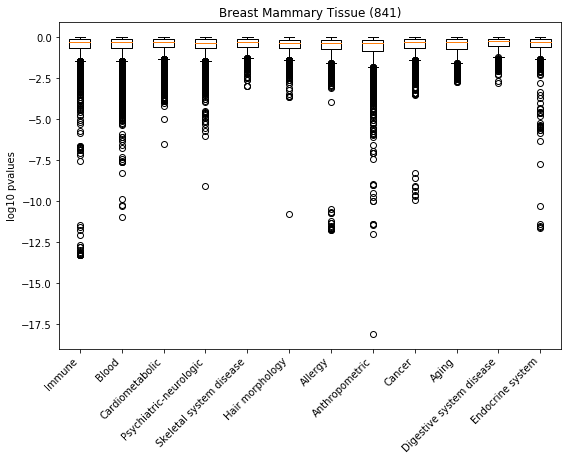

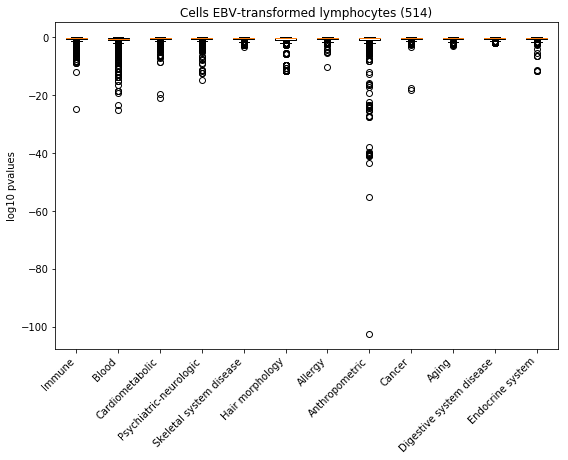

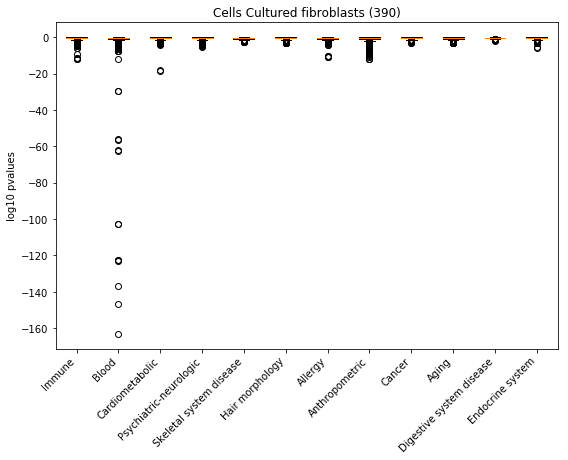

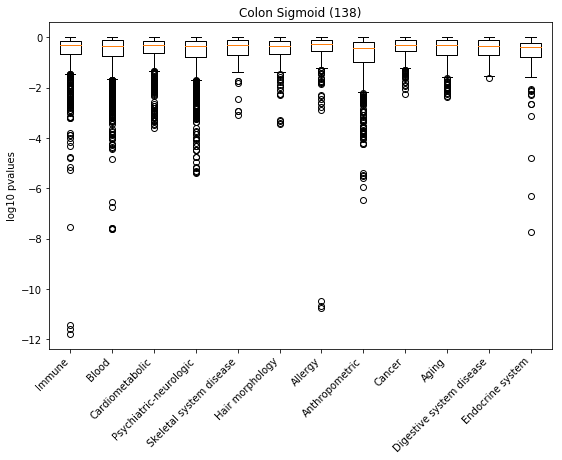

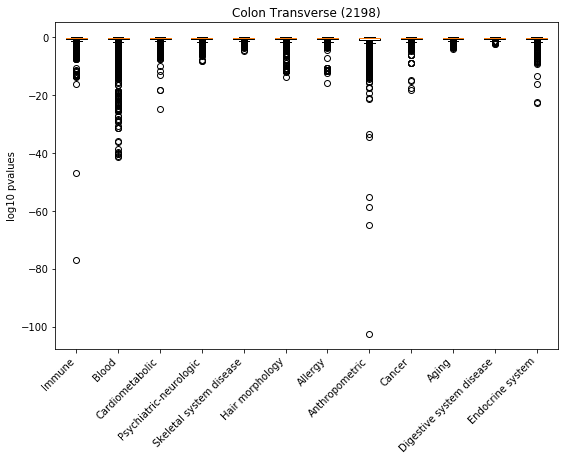

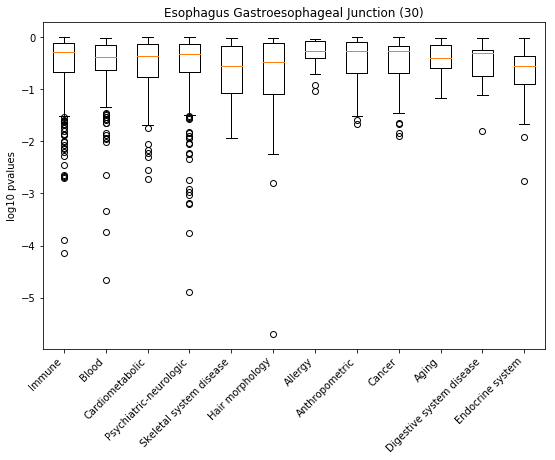

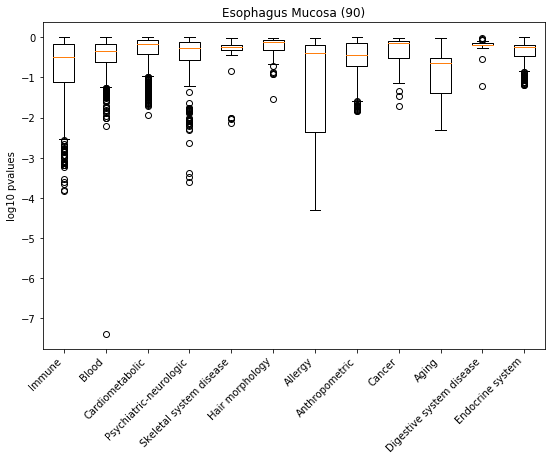

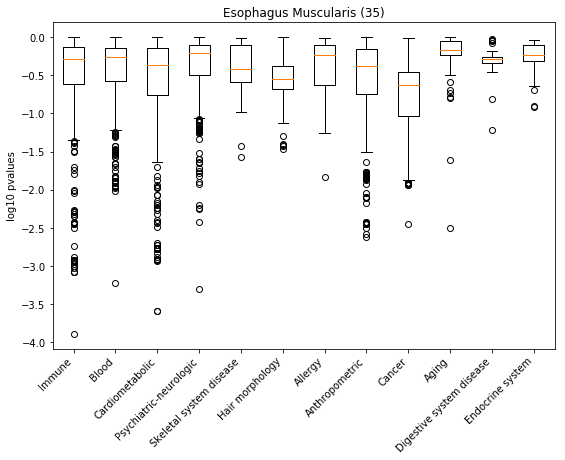

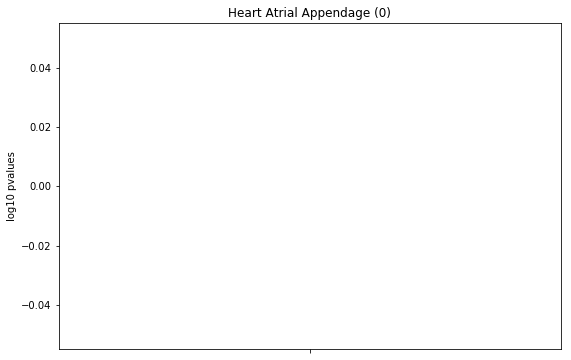

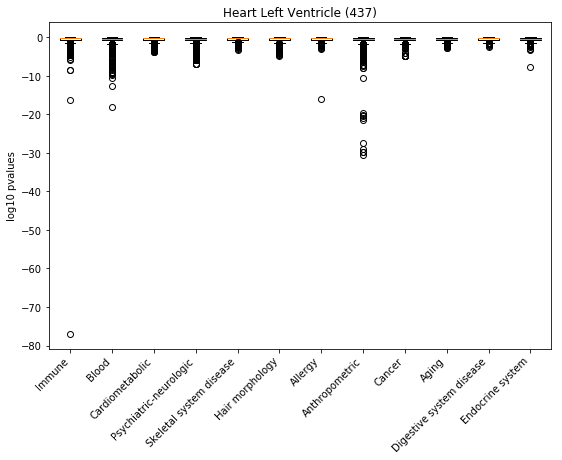

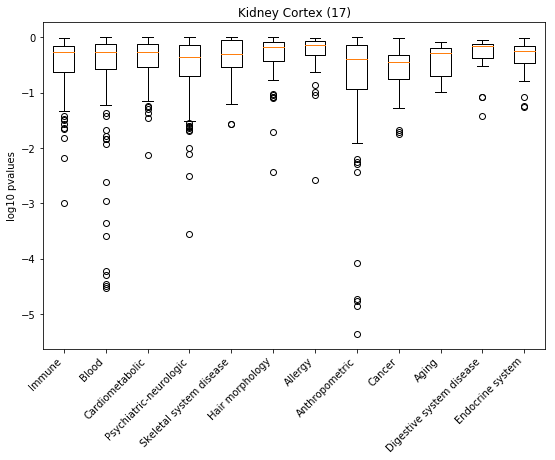

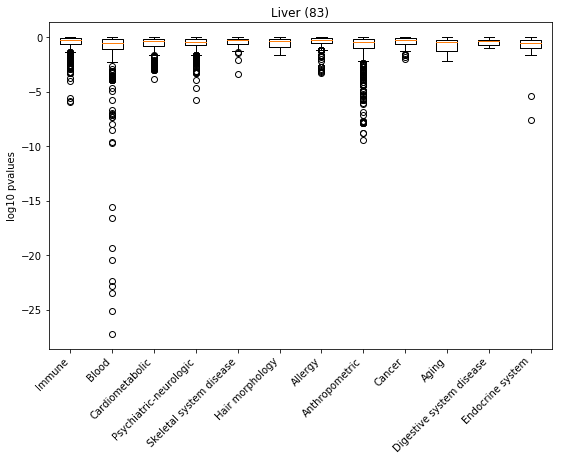

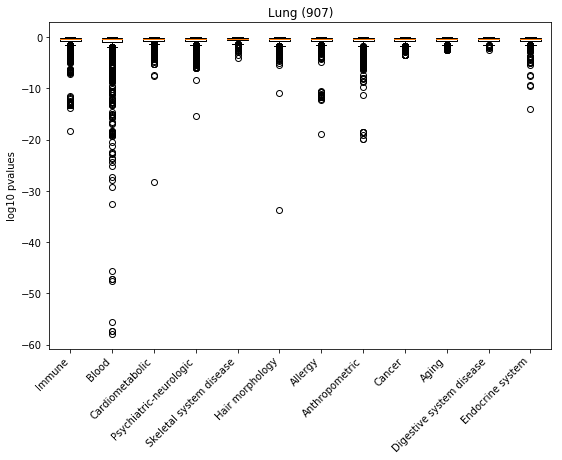

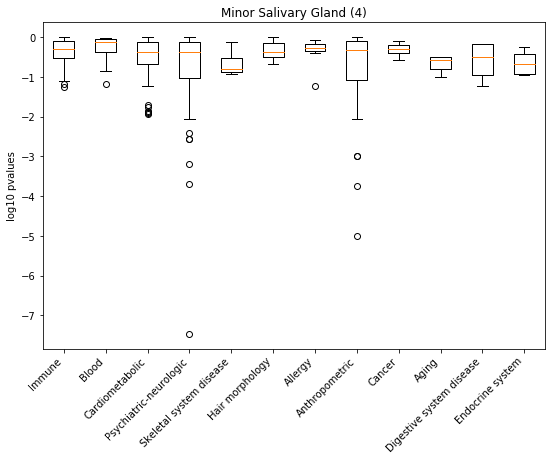

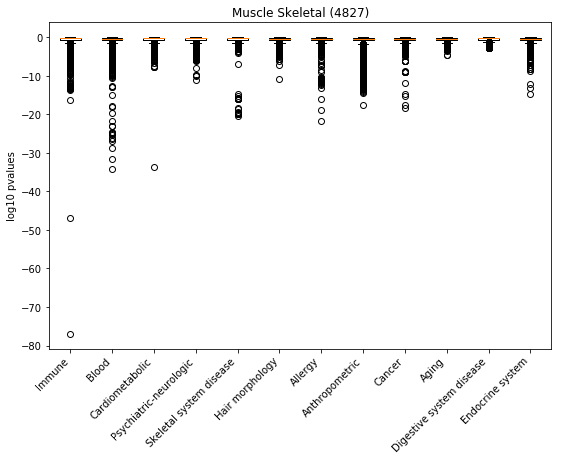

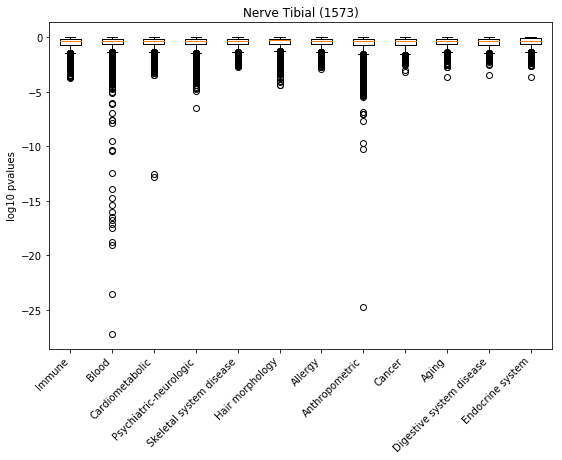

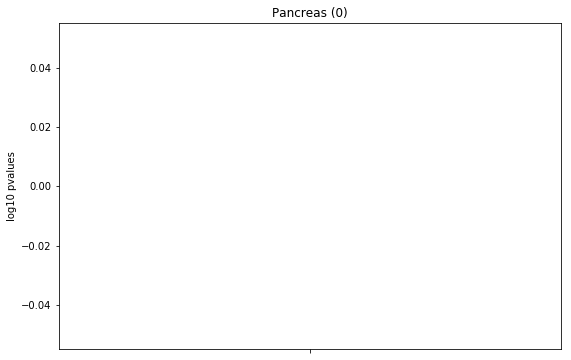

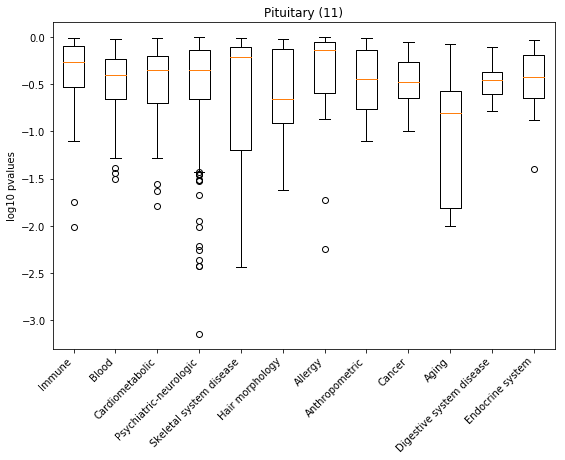

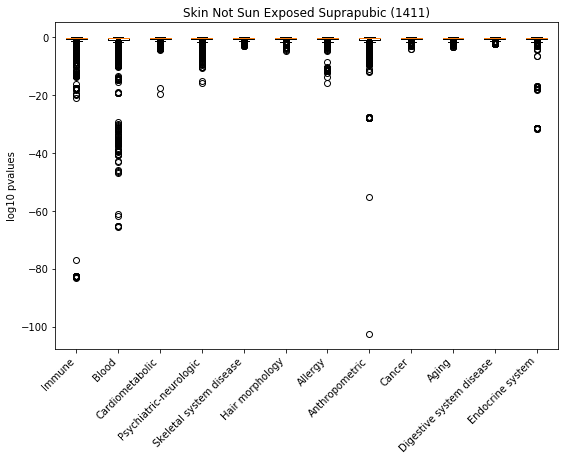

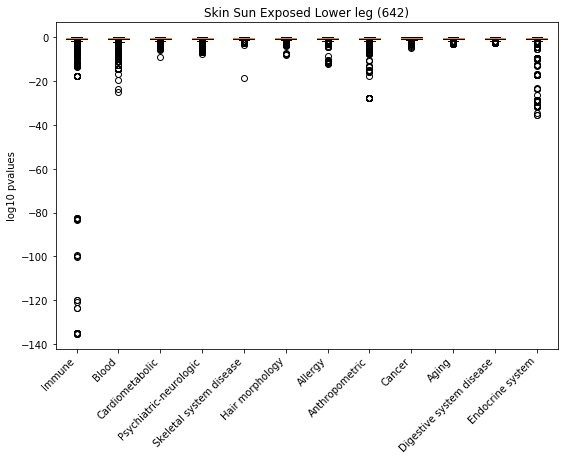

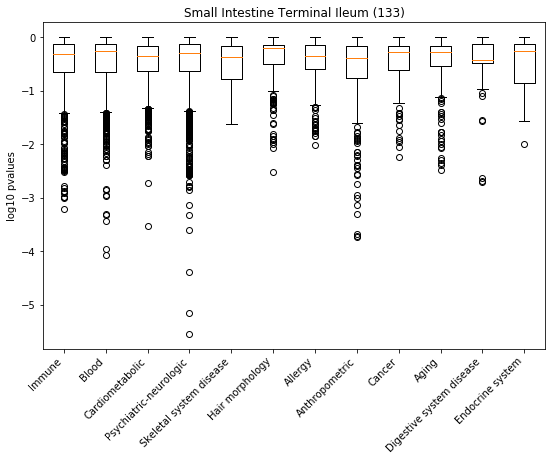

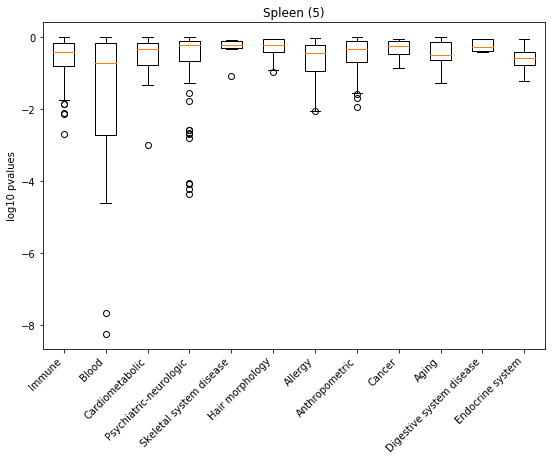

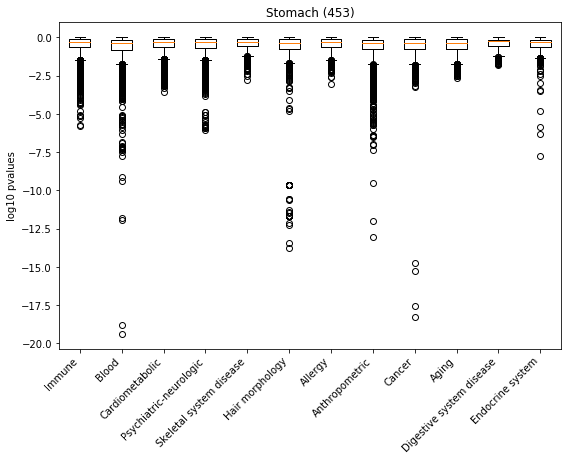

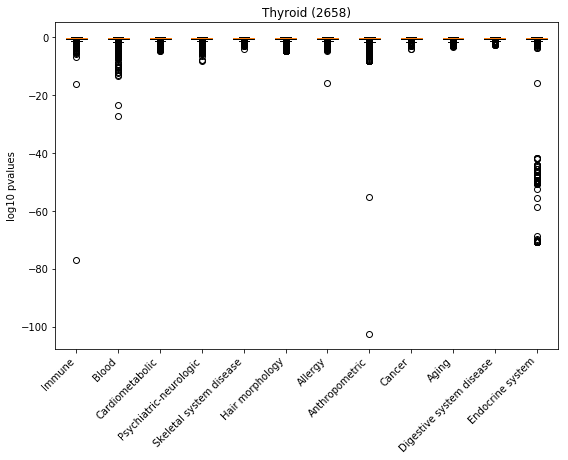

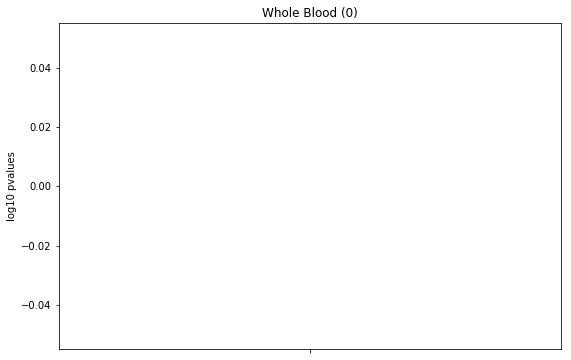

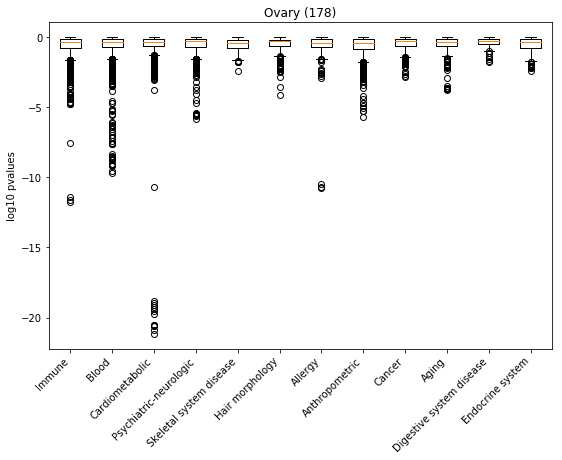

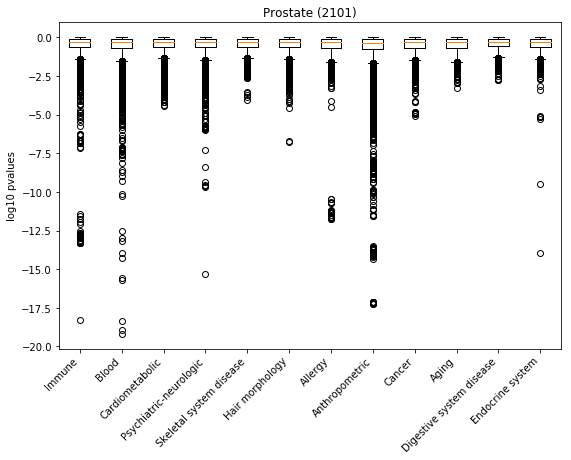

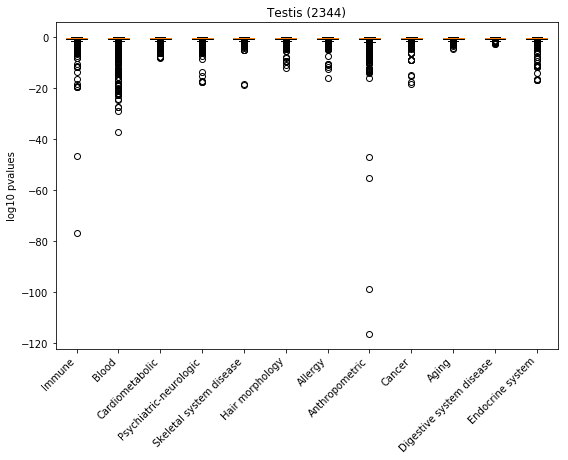

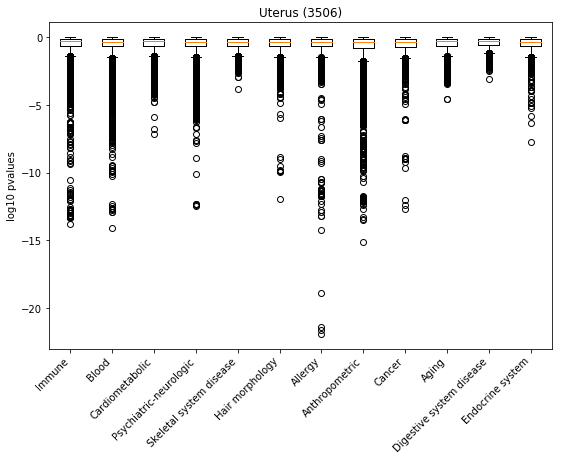

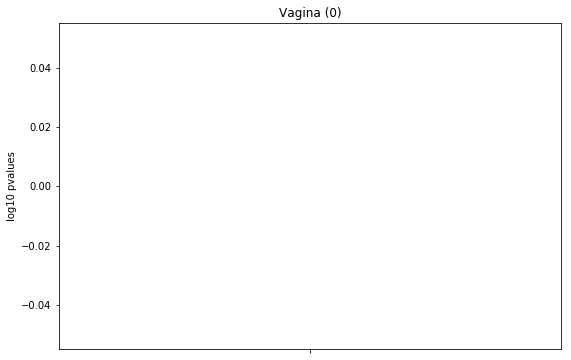

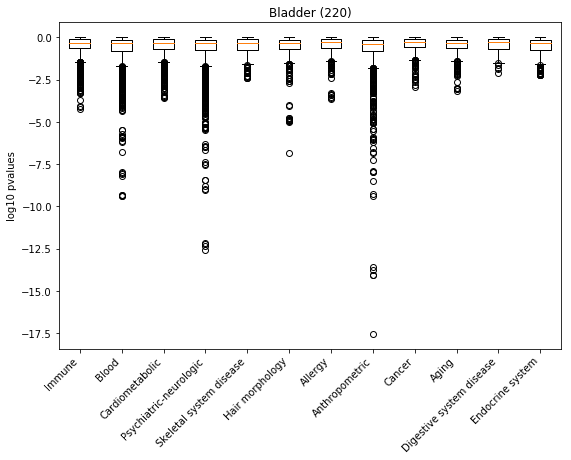

In [167]:
import matplotlib.pyplot as plt

for ts in tissuenames:
    fig = plt.figure(figsize=(9,6))
    ax1 = fig.add_subplot(111)
    ax1.boxplot([np.log10(gwas_studycat[ts][st]) for st in gwas_studycat[ts]])
    ax1.set_xticklabels(list(gwas_studycat[ts].keys()), ha="right", rotation=45)
    ax1.set_title(tissue_names[ts] + " ({:d})".format(len(res_gwas_dict[ts][0])))
    ax1.set_ylabel("log10 pvalues")
    plt.show()
